# Hodgkin-Huxley example

In [155]:
%load_ext autoreload
%autoreload 2

from typing import Any, Sequence
from copy import copy

import torch
import torch.utils.data as data

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
import distrax 
import optax

import sbi.utils as utils
import sbi.analysis as analysis
from sbi.inference import SNPE

from HH_helper_functions import syn_current, HHsimulator, calculate_summary_statistics

from jaxili.train import TrainerModule, TrainState
from jaxili.model import ConditionalMAF, ConditionalRealNVP
from jaxili.utils import create_data_loader

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
I, t_on, t_off, dt, t, A_soma = syn_current()

In [3]:
def run_HH_model(params):

    params = np.asarray(params)

    #input current, time step
    I, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I), 1)*dt

    #initial voltage
    V0 = -70

    states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

In [4]:
#three sets of g_Na, g_K)
params = np.array([[50.0, 1.0], [4.0, 1.5], [20.0, 15.0]])

num_samples = len(params[:, 0])
sim_samples = np.zeros((num_samples, len(I)))
for i in range(num_samples):
    sim_samples[i, :] = run_HH_model(params = params[i, :])["data"]

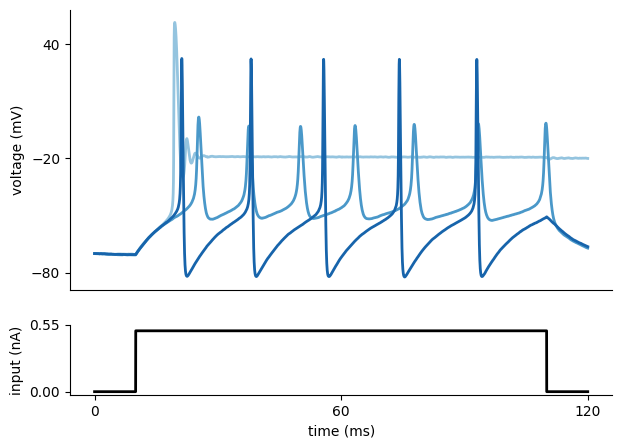

In [5]:
#colors for traces
col_min = 2

num_colors = num_samples + col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.0*i/num_colors) for i in range(col_min, num_colors)]

fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_samples):
    plt.plot(t, sim_samples[i,:], color=col1[i], lw=2)
plt.ylabel("voltage (mV)")
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t, I*A_soma*1e3, "k", lw=2)
plt.xlabel("time (ms)")
plt.ylabel("input (nA)")

ax.set_xticks([0, max(t)/2, max(t)])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))
plt.show()

In [6]:
def simulation_wrapper(params):
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

In [7]:
prior_min = [0.5, 1e-4]
prior_max = [80.0, 15.0]
prior = utils.torchutils.BoxUniform(
    low = torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

In [8]:
thetas = prior.sample((300,))
xs = torch.stack([simulation_wrapper(theta) for theta in thetas])
xs = torch.as_tensor(xs, dtype=torch.float32)

In [9]:
print(thetas.shape, xs.shape)

torch.Size([300, 2]) torch.Size([300, 7])


In [10]:
inference = SNPE(prior)

density_estimator = inference.append_simulations(thetas, xs).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 205 epochs.

In [11]:
type(density_estimator)

nflows.flows.base.Flow

In [12]:
inference_2 = SNPE(prior)

density_estimator_2 = inference_2.append_simulations(thetas, xs).train(max_num_epochs=-1)
pre_posterior = inference_2.build_posterior(density_estimator_2)

In [13]:
inference_2._neural_net.state_dict()

OrderedDict([('_transform._transforms.0._shift', tensor([-1.7246, -1.6976])),
             ('_transform._transforms.0._scale', tensor([0.0436, 0.2362])),
             ('_transform._transforms.1.autoregressive_net.initial_layer.weight',
              tensor([[ 0.6505, -0.1488],
                      [-0.5562,  0.6946],
                      [-0.5404,  0.5555],
                      [-0.5387, -0.2949],
                      [-0.0185,  0.6971],
                      [-0.1125, -0.1991],
                      [-0.1307, -0.1639],
                      [ 0.3200,  0.4816],
                      [ 0.1053,  0.3046],
                      [-0.1387,  0.5643],
                      [-0.5026,  0.6103],
                      [-0.6691, -0.6472],
                      [-0.4153, -0.3211],
                      [-0.1130, -0.3224],
                      [ 0.1888, -0.0995],
                      [-0.5261,  0.3351],
                      [ 0.5961, -0.3771],
                      [ 0.0824, -0.0634],
        

In [14]:
true_params = np.array([50.0, 5.0])
labels_params = [r"$g_{Na}$", r"$g_{K}$"]

observation_trace = run_HH_model(true_params)
observation_summary_statistics = calculate_summary_statistics(observation_trace)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

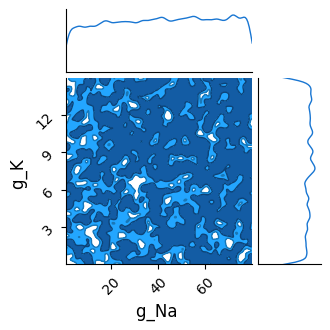

In [15]:
pre_samples = pre_posterior.sample((10000,), x=observation_summary_statistics)

c = ChainConsumer()
c.add_chain(pre_samples.numpy(), parameters=["g_Na", "g_K"])
fig = c.plotter.plot()
plt.show()

In [16]:
samples = posterior.sample((10000,), x=observation_summary_statistics)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

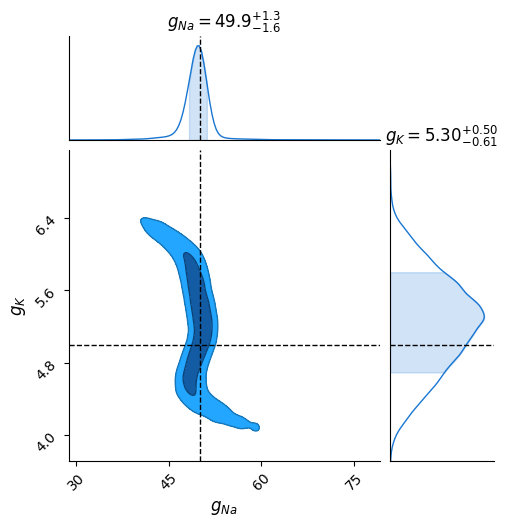

In [17]:
c = ChainConsumer()
c.add_chain(samples.numpy(), parameters=labels_params)
fig = c.plotter.plot(figsize="column", truth=true_params)
plt.show()

In [18]:
#using jaxili

#Create the dataset
class HH_dataset(data.Dataset):
    def __init__(self, thetas, xs):
        self.thetas = thetas.numpy()
        self.xs = xs.numpy()

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]
    
def generate_dataset(num_samples):
    thetas = prior.sample((num_samples,))
    xs = torch.stack([simulation_wrapper(theta) for theta in thetas])
    xs = torch.as_tensor(xs, dtype=torch.float32)
    return thetas, xs

train_set = HH_dataset(thetas, xs)
val_set = HH_dataset(*generate_dataset(100))
test_set = HH_dataset(*generate_dataset(200))

#Create the model
train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train=[True, False, False],
    batch_size=50
)

In [192]:
class MAFTrainer(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_cond : int,
                 n_layers : int,
                 layers : list[int],
                 use_reverse : bool,
                 seed : int = 42,
                 activation : str = 'silu',
                 prior : Any = None,
                 trial : Any = None,
                 **kwargs
                 ):
        super().__init__(model_class=ConditionalMAF,
                         model_hparams={
                             'n_in': n_in,
                             'n_cond': n_cond,
                             'n_layers': n_layers,
                             'layers': layers,
                             'use_reverse': use_reverse,
                             'seed': seed,
                             'activation': activation,
                             'prior': prior
                         },
                         
                         **kwargs)
        self.trial = trial
        
    def create_functions(self):
        def loss_nll(params, batch, train):
            thetas, xs = batch
            output, updates = self.model.apply(
                {'params': params},
                  thetas, xs, train,
                  mutable=['batch_stats'], method='log_prob')
            return -jnp.mean(output), (output)
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch, train=True)
            (loss, (updates)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            #print(loss)
            state = state.apply_gradients(grads=grads)
            #state = state.replace(batch_stats=updates['batch_stats'])
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss, _ = loss_nll(state.params, batch, train=False)
            return {'loss': loss}
        
        return train_step, eval_step
    
    def init_optimizer(self,
                       num_epochs : int,
                       num_steps_per_epoch : int):
        """
        Initializes the optimizer and learning rate scheduler.

        Parameters
        ----------
        num_epochs : Number of epochs to train.
        num_steps_per_epoch : Number of steps per epoch.
        """

        hparams = copy(self.optimizer_hparams)

        #Initialize optimizer
        optimizer_name = hparams.pop('optimizer_name', 'adam')
        if optimizer_name.lower() == 'adam':
            opt_class = optax.adam
        elif optimizer_name.lower() == 'sgd':
            opt_class = optax.sgd
        elif optimizer_name.lower() == 'adamw':
            opt_class = optax.adamw
        else:
            assert False, f'Unknown optimizer \"{optimizer_name}\"'
        #Initialize learning rate scheduler
        #A cosine decay scheduler is used, but others are also possible
        lr = hparams.pop('lr', 1e-3)
        warmup = hparams.pop('warmup', 0.1)
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=lr,
            warmup_steps=warmup,
            decay_steps=int(num_epochs * num_steps_per_epoch),
            end_value=0.01 * lr
        )
        #Clip gradients at max value, and evt. apply weight decay
        transf = [optax.clip_by_global_norm(hparams.pop('gradient_clip', 5.0))]
        if opt_class == optax.sgd and 'weight_decay' in hparams:
            transf.append(optax.add_decayed_weights(hparams.pop('weight_decay', 0.0)))
        optimizer = optax.chain(
            *transf,
            opt_class(lr_schedule, **hparams)
        )
        #Initialize training state
        self.state = TrainState.create(
            apply_fn=self.state.apply_fn,
            params=self.state.params,
            batch_stats=self.state.batch_stats,
            tx=optimizer,
            rng=self.state.rng
        )
        
    def generate_config(self, logger_params):
        self.config = {
            'model_class': self.model_class.__name__,
            'model_hparams': copy(self.model_hparams),
            'optimizer_hparams': self.optimizer_hparams,
            'logger_params': logger_params,
            'enable_progress_bar': self.enable_progress_bar,
            'debug': self.debug,
            'check_val_every_epoch': self.check_val_every_epoch,
            'seed': self.seed
        }
        self.config['model_hparams']['prior'] = 'Uniform'
        
        
    def print_tabulate(self, exmp_input):
        pass

In [193]:
class Uniform2D(distrax.Distribution):
    def __init__(self, low, high):
        self._low = low
        self._high = high

    @property
    def low(self):
        return self._low

    @property
    def high(self):
        return self._high

    def log_prob(self, value):
        log_prob = jnp.sum(distrax.Uniform(self.low, self.high).log_prob(value), axis=-1)
        return log_prob

    def _sample_n(self, seed, sample_shape):
        return distrax.Uniform(self.low, self.high).sample(seed=seed, sample_shape=sample_shape) 

    def event_shape(self):
        return distrax.Uniform(self.low, self.high).event_shape   

prior_jax = Uniform2D(low=jnp.array(prior_min), high=jnp.array(prior_max))

prior_jax.sample(seed=42, sample_shape=(10,))

Array([[19.735558 ,  8.609738 ],
       [35.401318 ,  3.1188052],
       [29.969343 , 14.6984415],
       [78.160225 ,  5.4365115],
       [26.01314  ,  8.174169 ],
       [31.668081 ,  8.82661  ],
       [53.39278  ,  2.075016 ],
       [59.84369  ,  1.0038975],
       [38.311386 , 12.070664 ],
       [27.57102  ,  9.010707 ]], dtype=float32)

In [194]:
mean = distrax.Uniform(jnp.array(prior_min), jnp.array(prior_max)).mean()
std = jnp.sqrt(distrax.Uniform(jnp.array(prior_min), jnp.array(prior_max)).variance())

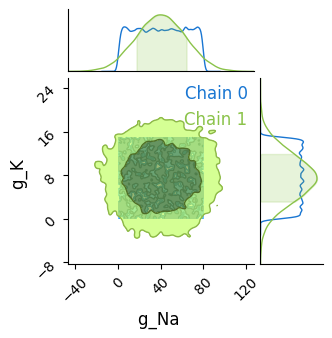

In [195]:
prior_normal = distrax.MultivariateNormalDiag(mean, std)

samples_normal = prior_normal.sample(seed=42, sample_shape=(10000,))
samples_uni = prior_jax.sample(seed=42, sample_shape=(10000,))

c = ChainConsumer()
c.add_chain(samples_uni, parameters=["g_Na", "g_K"])
c.add_chain(samples_normal, parameters=["g_Na", "g_K"])
fig = c.plotter.plot()
plt.show()

In [196]:
CHECKPOINT_PATH = '~/Documents/SBI/sbi_jax/notebooks/checkpoints'

trainer = MAFTrainer(
    n_in=2,
    n_cond=7,
    n_layers=5,
    layers=[50, 50],
    use_reverse=True,
    seed=30,
    activation='relu',
    prior=prior_normal,
    optimizer_hparams={
        'lr': 5e-3,
        'optimizer_name': 'adam'
    },
    logger_params={'base_log_dir': CHECKPOINT_PATH},
    exmp_input=next(iter(train_loader)),
    check_val_every_epoch=1,
    trial=None,
    debug=False
)

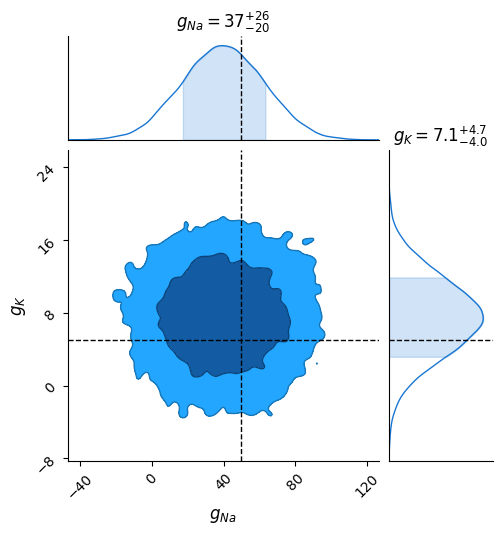

In [197]:
key = jax.random.PRNGKey(42)
pre_samples = trainer.model.apply(
    {'params': trainer.state.params}, observation_summary_statistics.reshape((-1, 7)), num_samples=10000, key=key, method='sample'
)

c = ChainConsumer()
c.add_chain(pre_samples, parameters=labels_params)
fig = c.plotter.plot(figsize="column", truth=true_params)
plt.show()

In [198]:
trainer.state.params

{'layer_list_0': {'ConditionalMADE_0': {'layers_0': {'Dense_0': {'kernel': Array([[ 7.15936953e-03,  6.16055587e-03, -7.25786947e-03,
             -7.71624560e-04, -2.51256372e-03,  8.96579400e-03,
             -7.19987415e-03,  8.41997098e-03,  1.46400509e-03,
              5.42372745e-03, -1.40737956e-02,  5.90637140e-03,
             -3.12761427e-03,  1.36629986e-02, -2.46096239e-03,
              1.32803386e-02,  5.33229113e-03, -1.10198259e-02,
              1.33980103e-02, -1.22190118e-04,  3.27070802e-03,
              1.12143280e-02, -1.11046610e-02, -1.26065351e-02,
              8.17432068e-03, -1.00590475e-02, -1.21866819e-02,
             -9.05267429e-03,  5.64356428e-03,  2.37286673e-03,
              2.62524304e-03, -9.54818912e-03,  1.61425192e-02,
              6.33796304e-03,  5.13219927e-03, -5.38471108e-03,
             -2.96553224e-03,  6.96427072e-04,  1.88763766e-03,
             -6.98278472e-03,  6.20205607e-03,  4.59443685e-03,
             -1.49557739e-03,  5.3

In [199]:
trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=200
)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:absl:Saving checkpoint at step: 1
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_1.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/chec

Training:   0%|          | 0/6 [00:00<?, ?it/s]

/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:absl:Saving checkpoint at step: 2
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_2.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/chec

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 3
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_3.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_3.orbax-checkpoint-tmp-1709743468700145 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_3
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_3`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_2


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 4
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_4.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_4.orbax-checkpoint-tmp-1709743468899250 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_4
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_4`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_3


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 5
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_5.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_5.orbax-checkpoint-tmp-1709743469097411 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_5
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_5`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_4


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 8
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_8.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_8.orbax-checkpoint-tmp-1709743469723974 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_8
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_8`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_5


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 12
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_12.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_12.orbax-checkpoint-tmp-1709743470526161 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_12
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_12`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_8


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 13
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_13.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_13.orbax-checkpoint-tmp-1709743470754977 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_13
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_13`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_12


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 14
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_14.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_14.orbax-checkpoint-tmp-1709743470953195 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_14
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_14`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_13


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 15
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_15.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_15.orbax-checkpoint-tmp-1709743471147016 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_15
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_15`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_14


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 19
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_19.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_19.orbax-checkpoint-tmp-1709743471963568 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_19
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_19`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_15


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 21
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_21.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_21.orbax-checkpoint-tmp-1709743472355007 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_21
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_21`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_19


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 26
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_26.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_26.orbax-checkpoint-tmp-1709743473388593 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_26
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_26`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_21


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 30
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_30.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_30.orbax-checkpoint-tmp-1709743474176936 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_30
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_30`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_26


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 31
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_31.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_31.orbax-checkpoint-tmp-1709743474395878 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_31
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_31`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_30


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 33
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_33.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_33.orbax-checkpoint-tmp-1709743474822748 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_33
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_33`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_31


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 34
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_34.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_34.orbax-checkpoint-tmp-1709743475041451 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_34
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_34`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_33


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 51
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_51.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_51.orbax-checkpoint-tmp-1709743478422042 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_51
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_51`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_34


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 66
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_66.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_66.orbax-checkpoint-tmp-1709743481492625 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_66
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_66`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_51


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 70
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_70.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_70.orbax-checkpoint-tmp-1709743482325272 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_70
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_70`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_66


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 75
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_75.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_75.orbax-checkpoint-tmp-1709743483352035 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_75
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_75`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_70


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 77
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_77.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_77.orbax-checkpoint-tmp-1709743483794103 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_77
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_77`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_75


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 82
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_82.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_82.orbax-checkpoint-tmp-1709743484825684 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_82
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_82`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_77


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 84
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_84.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_84.orbax-checkpoint-tmp-1709743485227397 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_84
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_84`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_82


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 92
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_92.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_92.orbax-checkpoint-tmp-1709743486910245 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_92
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_92`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_84


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 94
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_94.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_94.orbax-checkpoint-tmp-1709743487372173 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_94
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_94`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_92


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 100
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_100.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_100.orbax-checkpoint-tmp-1709743488599857 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_100
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_100`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_94


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 101
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_101.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_101.orbax-checkpoint-tmp-1709743488819444 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_101
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_101`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 103
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_103.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_103.orbax-checkpoint-tmp-1709743489336472 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_103
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_103`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_101


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 104
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_104.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_104.orbax-checkpoint-tmp-1709743489557779 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_104
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_104`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_103


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 105
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_105.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_105.orbax-checkpoint-tmp-1709743489766924 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_105
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_105`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_104


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 109
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_109.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_109.orbax-checkpoint-tmp-1709743490576835 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_109
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_109`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_105


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 113
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_113.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_113.orbax-checkpoint-tmp-1709743491548332 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_113
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_113`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_109


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 114
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_114.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_114.orbax-checkpoint-tmp-1709743491808373 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_114
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_114`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_113


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 115
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_115.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_115.orbax-checkpoint-tmp-1709743492065747 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_115
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_115`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_114


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 116
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_116.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_116.orbax-checkpoint-tmp-1709743492292779 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_116
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_116`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_115


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 117
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_117.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_117.orbax-checkpoint-tmp-1709743492499589 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_117
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_117`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_116


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 118
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_118.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_118.orbax-checkpoint-tmp-1709743492777242 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_118
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_118`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_117


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 119
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_119.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_119.orbax-checkpoint-tmp-1709743492982969 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_119
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_119`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_118


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 120
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_120.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_120.orbax-checkpoint-tmp-1709743493231098 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_120
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_120`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_119


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 122
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_122.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_122.orbax-checkpoint-tmp-1709743493669954 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_122
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_122`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_120


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 138
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_138.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_138.orbax-checkpoint-tmp-1709743497048358 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_138
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_138`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_122


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 139
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_139.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_139.orbax-checkpoint-tmp-1709743497316264 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_139
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_139`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_138


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 157
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_157.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_157.orbax-checkpoint-tmp-1709743501049662 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_157
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_157`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_139


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 158
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_158.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_158.orbax-checkpoint-tmp-1709743501273740 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_158
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_158`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_157


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 161
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_161.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_161.orbax-checkpoint-tmp-1709743501919777 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_161
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_161`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_158


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 165
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_165.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_165.orbax-checkpoint-tmp-1709743502771310 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_165
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_165`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_161


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 167
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_167.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_167.orbax-checkpoint-tmp-1709743503159150 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_167
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_167`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_165


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 168
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_168.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_168.orbax-checkpoint-tmp-1709743503390263 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_168
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_168`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_167


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 169
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_169.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_169.orbax-checkpoint-tmp-1709743503618964 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_169
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_169`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_168


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 174
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_174.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_174.orbax-checkpoint-tmp-1709743504621786 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_174
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_174`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_169


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 178
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_178.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_178.orbax-checkpoint-tmp-1709743505489703 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_178
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_178`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_174


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 180
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_180.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_180.orbax-checkpoint-tmp-1709743505901698 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_180
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_180`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_178


Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 181
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_181.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_181.orbax-checkpoint-tmp-1709743506183427 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_181
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_181`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_180


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 187
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_187.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_187.orbax-checkpoint-tmp-1709743507435697 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_187
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_187`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_181


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 189
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_189.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_189.orbax-checkpoint-tmp-1709743507884319 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_189
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_189`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_187


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 192
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_192.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_192.orbax-checkpoint-tmp-1709743508550495 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_192
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_192`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_189


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

Training:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 200
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_200.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_200.orbax-checkpoint-tmp-1709743510318206 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_200
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_200`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_75/checkpoint_192
INFO:absl:Restoring orbax checkpoint from /local/hom

{'val/loss': 3.5799670219421387,
 'train/loss': 3.453284740447998,
 'epoch_time': 0.021167278289794922,
 'test/loss': 3.5056819915771484}

In [200]:
model = trainer.bind_model()

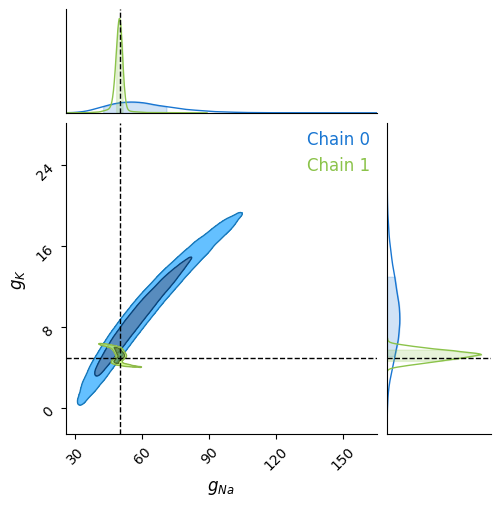

In [201]:
key = jax.random.PRNGKey(42)
jaxili_samples = model.sample(observation_summary_statistics.reshape((-1, 7)), num_samples=10000, key=key)

c = ChainConsumer()
c.add_chain(jnp.flip(jaxili_samples, axis=-1), parameters=labels_params)
c.add_chain(samples.numpy(), parameters=labels_params)
fig = c.plotter.plot(figsize="column", truth=true_params)
plt.show()

In [208]:
import optuna

CHECKPOINT_PATH = '/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_Hodgkin-Huxley'

def objective(trial):
    my_train_loader, my_val_loader = create_data_loader(train_set, val_set,
                                                         train=[True, False],
                                                         batch_size=256)
    trainer = MAFTrainer(n_in=2, #Create your trainer
                         n_cond=7,
                            n_layers=trial.suggest_int('n_layers', 2, 5),
                            layers=[50, 50],
                            prior=prior_normal,
                            use_reverse=trial.suggest_categorical('use_reverse', [True, False]),
                            activation='silu',
                            optimizer_hparams={
                                  'lr': trial.suggest_float('lr', 5e-5, 1e-2, log=True)
                              },
                            logger_params={'base_log_dir': CHECKPOINT_PATH},
                            exmp_input=next(iter(my_train_loader)), #beware of the training input.
                            check_val_every_epoch=1,
                            enable_progress_bar=False,
                            trial=trial)
    metrics = trainer.train_model(my_train_loader,
                                  my_val_loader,
                                  num_epochs=200)
    del trainer
    del my_train_loader, my_val_loader
    return metrics['val/loss']

In [209]:
study = optuna.create_study(
    study_name='maf_HH_hparam_search',
    storage=f'sqlite:///{CHECKPOINT_PATH}/maf_hparam_search.db',
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    load_if_exists=True
)
study.optimize(objective, n_trials=25-len(study.trials), n_jobs=1)

[I 2024-03-06 17:55:18,751] A new study created in RDB with name: maf_HH_hparam_search
Missing logger folder: /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_Hodgkin-Huxley/ConditionalMAF/
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:absl:Saving checkpoint at step: 1
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting


Neural network training stopped after 188 epochs.
Early stopping with best validation metric: 7.4391770362854
Best model saved at epoch 188
Early stopping parameters: min_delta=0.001, patience=20


/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:absl:Saving checkpoint at step: 1
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_Hodgkin-Huxley/ConditionalMAF/version_3/checkpoint_1.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/

Neural network training stopped after 199 epochs.
Early stopping with best validation metric: 7.410091400146484
Best model saved at epoch 199
Early stopping parameters: min_delta=0.001, patience=20


/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:absl:Saving checkpoint at step: 1
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_Hodgkin-Huxley/ConditionalMAF/version_7/checkpoint_1.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/

Neural network training stopped after 80 epochs.
Early stopping with best validation metric: 6.123987197875977
Best model saved at epoch 59
Early stopping parameters: min_delta=0.001, patience=20


/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:absl:Saving checkpoint at step: 1
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_Hodgkin-Huxley/ConditionalMAF/version_8/checkpoint_1.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/

Neural network training stopped after 53 epochs.
Early stopping with best validation metric: 6.831168174743652
Best model saved at epoch 32
Early stopping parameters: min_delta=0.001, patience=20


/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:absl:Saving checkpoint at step: 1
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_Hodgkin-Huxley/ConditionalMAF/version_11/checkpoint_1.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax

Neural network training stopped after 104 epochs.
Early stopping with best validation metric: 5.65785026550293
Best model saved at epoch 83
Early stopping parameters: min_delta=0.001, patience=20


/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:absl:Saving checkpoint at step: 1
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_Hodgkin-Huxley/ConditionalMAF/version_15/checkpoint_1.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax

Neural network training stopped after 67 epochs.
Early stopping with best validation metric: 6.358903884887695
Best model saved at epoch 46
Early stopping parameters: min_delta=0.001, patience=20


/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:absl:Saving checkpoint at step: 1
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints_Hodgkin-Huxley/ConditionalMAF/version_16/checkpoint_1.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax